# Importing Libraries

In [ ]:
seed_value= 0

import torch, torchvision
import glob
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import numpy as np
np.random.seed(seed_value)
import cv2
import random
random.seed(seed_value)
import itertools
import pandas as pd
#from tqdm import tqdm
import urllib
import json
import PIL.Image as Image
import shutil
from os.path import exists
from tqdm.auto import  tqdm
import imagehash
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime

from sklearn.metrics import classification_report, confusion_matrix


main_path = "../input/chithra-priya-crackgroove/Train/Train/"
path_groove = main_path + 'Cracks/'
path_crack = main_path + 'Groove/'

# Load and visualize the train set

In [ ]:
main_df = pd.DataFrame()
main_df['images'] = os.listdir(path_groove) + os.listdir(path_crack)

In [ ]:
classes = []
paths = []
for image in main_df['images']:
    class_ = image.split('_')[0]
    if class_ == 'Crack':
        class_+=str('s')
    classes.append(class_)
    paths.append(main_path+class_+'/'+image)

In [ ]:
main_df['classes'] = classes
main_df['path'] = paths

In [ ]:
main_df.tail()

,images,classes,path
4045,Groove_152.jpg,Groove,../input/chithra-priya-crackgroove/Train/Train...
4046,Groove_839.jpg,Groove,../input/chithra-priya-crackgroove/Train/Train...
4047,Groove_1362.jpg,Groove,../input/chithra-priya-crackgroove/Train/Train...
4048,Groove_383.jpg,Groove,../input/chithra-priya-crackgroove/Train/Train...
4049,Groove_1423.jpg,Groove,../input/chithra-priya-crackgroove/Train/Train...


In [ ]:
def plot_species(df,defect_name):
    plt.figure(figsize = (12,12))
    species_df = df[df['classes'] == defect_name].reset_index(drop = True)
    plt.suptitle(defect_name)
    for idx,i in enumerate(np.random.choice(species_df['path'],32)):
        plt.subplot(8,8,idx+1)
        image_path = i
        img = Image.open(image_path)
        img = img.resize((224,224))
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

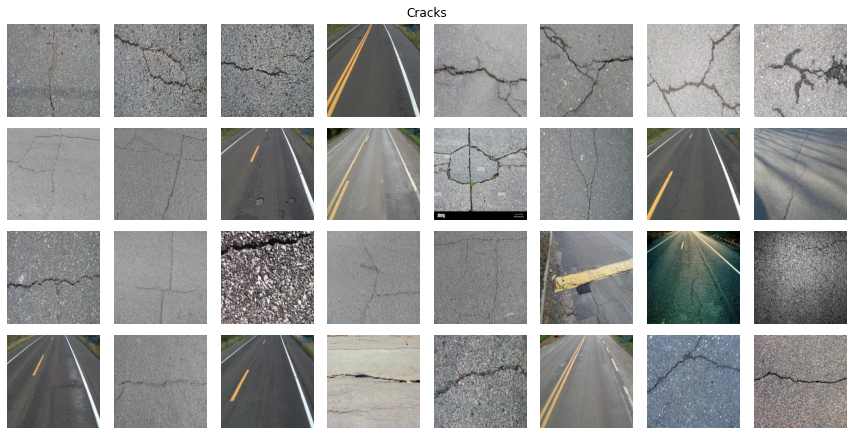

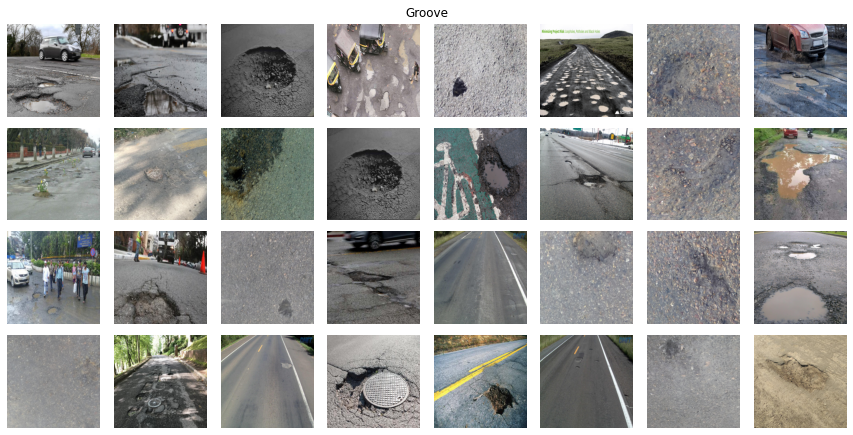

In [ ]:
for defect_name in main_df['classes'].unique():
    plot_species(main_df , defect_name)

In [ ]:
class_names = sorted(os.listdir(main_path))
class_names

['Cracks', 'Groove']

In [ ]:
n_classes = len(class_names)
print(f"Total Number of Classes : {n_classes}")

Total Number of Classes : 2


In [ ]:
class_dis = [len(os.listdir(main_path + name)) for name in class_names]
class_dis

[2025, 2025]

In [ ]:
fig = px.pie(names=class_names, values=class_dis)
fig.update_layout({'title':{
    'text':'Class Distribution',
    'x':0.5
}})
fig.show()

# Load the dataset

In [ ]:
train_path = '../input/chithra-priya-crackgroove/Train/Train/'
test_path = '../input/chithra-priya-crackgroove/Test/Test/'

train_names = sorted(os.listdir(train_path))
test_names = sorted(os.listdir(test_path))

assert train_names == test_names

n_classes = len(train_names)
print(f"Total Number of Classes : {n_classes}")

Total Number of Classes : 2


In [ ]:
import tensorflow
from tensorflow import keras

# Data 
from keras.preprocessing.image import ImageDataGenerator

# Model 
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Transfer Learning Models 
from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2, MobileNetV2, InceptionResNetV2

# set random set
tensorflow.random.set_seed(seed_value)

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Initialize Generator
train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True, 
    rotation_range=20,
    validation_split=0.2
)

test_gen = ImageDataGenerator(rescale=1./255)

# Load Data
train_ds = train_gen.flow_from_directory(
    train_path,
    class_mode='binary',
    shuffle=True,
    batch_size=32,
    target_size=(256,256),
    subset="training"
)

val_ds = train_gen.flow_from_directory(
    train_path,
    class_mode='binary',
    shuffle=True,
    batch_size=32,
    target_size=(256,256),
    subset="validation"
)

test_ds = test_gen.flow_from_directory(
    test_path,
    class_mode='binary',
    shuffle=False,
    batch_size=32,
    target_size=(256,256),
)

Found 3240 images belonging to 2 classes.
Found 810 images belonging to 2 classes.
Found 450 images belonging to 2 classes.


# Train the models

## 1. ResNet152V2

In [ ]:
# Set Name
name = "ResNet152V2"

# Load Pretrained Model
base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
resnet = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_resnet = resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs,
)

NameError: ignored

In [ ]:
model_resnet = load_model('./ResNet152V2.h5')
model_resnet.summary()

In [ ]:
model_resnet.evaluate(test_ds)

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_resnet.predict_generator(test_ds, 450 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['crack', 'groove']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

### The test results for ResNet152V2:
* Accuracy: **96-98%**
* F1 score: **96-98%**
* Precision: **96-98%**
* Recall: **96-98%**

## 2. Xception

In [ ]:
# Set Name
name = "Xception"

# Load Pretrained Model
base_model = Xception(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
xception = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
xception.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_xception = xception.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs
)

83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/10
102/102 [==============================] - 167s 2s/step - loss: 0.2521 - accuracy: 0.8978 - val_loss: 0.3514 - val_accuracy: 0.8568


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/10
102/102 [==============================] - 164s 2s/step - loss: 0.1713 - accuracy: 0.9364 - val_loss: 0.3321 - val_accuracy: 0.8741
Epoch 3/10
102/102 [==============================] - 163s 2s/step - loss: 0.1518 - accuracy: 0.9438 - val_loss: 0.2951 - val_accuracy: 0.8914
Epoch 4/10
102/102 [==============================] - 163s 2s/step - loss: 0.1439 - accuracy: 0.9426 - val_loss: 0.2312 - val_accuracy: 0.9160
Epoch 5/10
102/102 [==============================] - 164s 2s/step - loss: 0.1329 - accuracy: 0.9481 - val_loss: 0.2723 - val_accuracy: 0.8951
Epoch 6/10
102/102 [==============================] - 162s 2s/step - loss: 0.1267 - accuracy: 0.9543 - val_loss: 0.3229 - val_accuracy: 0.8790
Epoch 7/10
102/102 [==============================] - 162s 2s/step - loss: 0.1233 - accuracy: 0.9546 - val_loss: 0.2993 - val_accuracy: 0.9025
Epoch 8/10
102/102 [==============================] - 163s 2s/step - loss: 0.1143 - accuracy: 0.9614 - val_loss: 0.3111 - val_accuracy: 0.8889

In [ ]:
model_xception = load_model('./Xception.h5')
model_xception.summary()

Model: "Xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514

In [ ]:
model_xception.evaluate(test_ds)

15/15 [==============================] - 15s 865ms/step - loss: 0.1440 - accuracy: 0.9467


[0.14396344125270844, 0.9466666579246521]

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_xception.predict_generator(test_ds, 450 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['crack', 'groove']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Confusion Matrix
[[219   6]
 [ 18 207]]

Classification Report
              precision    recall  f1-score   support

       crack       0.92      0.97      0.95       225
      groove       0.97      0.92      0.95       225

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



### The test results for Xception:
* Accuracy: **94-95%**
* F1 score: **94-95%**
* Precision: **94-95%**
* Recall: **94-95%**

## 3. InceptionV3

In [ ]:
# Set Name
name = "InceptionV3"

# Load Pretrained Model
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
inception = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
inception.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_inception = inception.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs
)

NameError: ignored

In [ ]:
model_inception = load_model('./InceptionV3.h5')
model_inception.summary()

NameError: ignored

In [ ]:
model_inception.evaluate(test_ds)

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_inception.predict_generator(test_ds, 450 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['crack', 'groove']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

### The test results for InceptionV3:
* Accuracy: **94-95%**
* F1 score: **94-95%**
* Precision: **94-95%**
* Recall: **94-95%**

## 4. MobileNetV2 
(for embedded deployment)

In [ ]:
# Set Name
name = "MobileNetV2"

# Load Pretrained Model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
mobilenet = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
mobilenet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_mobilenet = mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs
)

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/10
102/102 [==============================] - 165s 2s/step - loss: 0.2731 - accuracy: 0.8883 - val_loss: 0.2265 - val_accuracy: 0.9086


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/10
102/102 [==============================] - 159s 2s/step - loss: 0.1589 - accuracy: 0.9441 - val_loss: 0.2044 - val_accuracy: 0.9259
Epoch 3/10
102/102 [==============================] - 164s 2s/step - loss: 0.1413 - accuracy: 0.9491 - val_loss: 0.2241 - val_accuracy: 0.9185
Epoch 4/10
102/102 [==============================] - 160s 2s/step - loss: 0.1280 - accuracy: 0.9515 - val_loss: 0.2012 - val_accuracy: 0.9309
Epoch 5/10
102/102 [==============================] - 160s 2s/step - loss: 0.1208 - accuracy: 0.9593 - val_loss: 0.2418 - val_accuracy: 0.9148
Epoch 6/10
102/102 [==============================] - 158s 2s/step - loss: 0.1201 - accuracy: 0.9565 - val_loss: 0.2113 - val_accuracy: 0.9198
Epoch 7/10
102/102 [==============================] - 165s 2s/step - loss: 0.1064 - accuracy: 0.9620 - val_loss: 0.2170 - val_accuracy: 0.9160
Epoch 8/10
102/102 [==============================] - 160s 2s/step - loss: 0.1079 - accuracy: 0.9608 - val_loss: 0.1704 - val_accuracy: 0.9309

In [ ]:
model_mobilenet = load_model('./MobileNetV2.h5')
model_mobilenet.summary()

Model: "MobileNetV2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 

In [ ]:
model_mobilenet.evaluate(test_ds)

15/15 [==============================] - 14s 816ms/step - loss: 0.1323 - accuracy: 0.9444


[0.13233976066112518, 0.9444444179534912]

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_mobilenet.predict_generator(test_ds, 450 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['crack', 'groove']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Confusion Matrix
[[216   9]
 [ 16 209]]

Classification Report
              precision    recall  f1-score   support

       crack       0.93      0.96      0.95       225
      groove       0.96      0.93      0.94       225

    accuracy                           0.94       450
   macro avg       0.94      0.94      0.94       450
weighted avg       0.94      0.94      0.94       450



### The test results for MobileNetV2:
* Accuracy: **94-95%**
* F1 score: **94-95%**
* Precision: **94-95%**
* Recall: **94-95%**

## 5. InceptionResNetV2

In [ ]:
# Set Name
name = "InceptionResNetV2"

# Load Pretrained Model
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
inceptionresnet = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
inceptionresnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_inceptionresnet = inceptionresnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs
)

219070464/219055592 [==============================] - 1s 0us/step
Epoch 1/10
102/102 [==============================] - 178s 2s/step - loss: 0.3185 - accuracy: 0.8648 - val_loss: 0.3024 - val_accuracy: 0.8679
Epoch 2/10
102/102 [==============================] - 164s 2s/step - loss: 0.1913 - accuracy: 0.9306 - val_loss: 0.2713 - val_accuracy: 0.8914
Epoch 3/10
102/102 [==============================] - 163s 2s/step - loss: 0.1777 - accuracy: 0.9312 - val_loss: 0.2382 - val_accuracy: 0.8951
Epoch 4/10
102/102 [==============================] - 162s 2s/step - loss: 0.1479 - accuracy: 0.9410 - val_loss: 0.2509 - val_accuracy: 0.9000
Epoch 5/10
102/102 [==============================] - 164s 2s/step - loss: 0.1545 - accuracy: 0.9392 - val_loss: 0.2274 - val_accuracy: 0.9049
Epoch 6/10
102/102 [==============================] - 163s 2s/step - loss: 0.1452 - accuracy: 0.9432 - val_loss: 0.3700 - val_accuracy: 0.8753
Epoch 7/10
102/102 [==============================] - 165s 2s/step - loss: 

In [ ]:
model_inceptionresnet = load_model('./InceptionResNetV2.h5')
model_inceptionresnet.summary()

Model: "InceptionResNetV2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1536)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               393472    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)           

In [ ]:
model_inceptionresnet.evaluate(test_ds)

15/15 [==============================] - 17s 879ms/step - loss: 0.1400 - accuracy: 0.9489


[0.14000608026981354, 0.948888897895813]

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_inceptionresnet.predict_generator(test_ds, 450 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['crack', 'groove']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Confusion Matrix
[[218   7]
 [ 16 209]]

Classification Report
              precision    recall  f1-score   support

       crack       0.93      0.97      0.95       225
      groove       0.97      0.93      0.95       225

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



### The test results for InceptionResNetV2:
* Accuracy: **94-96%**
* F1 score: **94-96%**
* Precision: **94-96%**
* Recall: **94-96%**

# Plot training losses

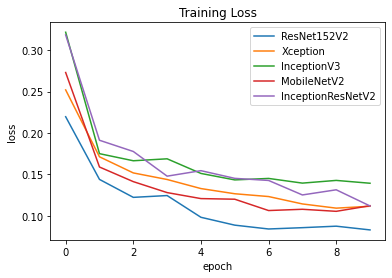

In [ ]:
# summarize history for loss
plt.plot(hist_resnet.history['loss'])
plt.plot(hist_xception.history['loss'])
plt.plot(hist_inception.history['loss'])
plt.plot(hist_mobilenet.history['loss'])
plt.plot(hist_inceptionresnet.history['loss'])

plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['ResNet152V2', 'Xception', 'InceptionV3', 'MobileNetV2', 'InceptionResNetV2'], loc='upper right')
plt.show()

# Plot training accuracy

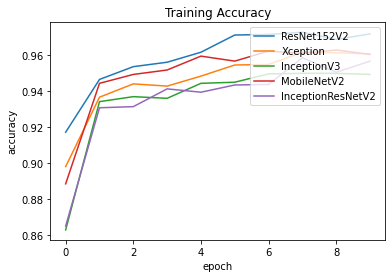

In [ ]:
plt.plot(hist_resnet.history['accuracy'])
plt.plot(hist_xception.history['accuracy'])
plt.plot(hist_inception.history['accuracy'])
plt.plot(hist_mobilenet.history['accuracy'])
plt.plot(hist_inceptionresnet.history['accuracy'])

plt.title('Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['ResNet152V2', 'Xception', 'InceptionV3', 'MobileNetV2', 'InceptionResNetV2'], loc='upper right')
plt.show()

# Prediction by the best model (ResNet152V2)

In [ ]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

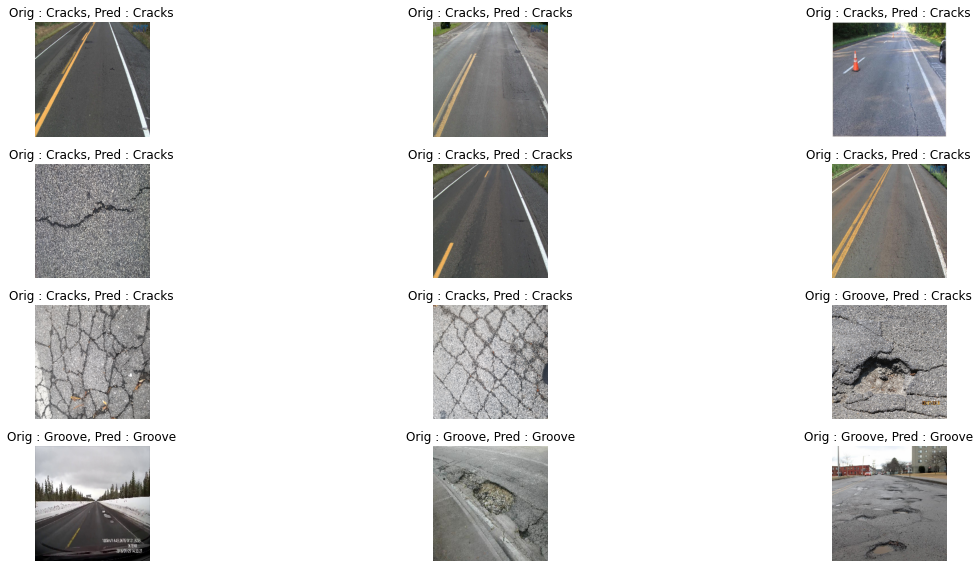

In [ ]:
i=1
plt.figure(figsize=(20,8))
for images, labels in test_ds:
    index = np.random.randint(len(images))
    image, label = images[index], class_names[int(labels[index])]
    pred_label = class_names[np.argmax(model_resnet.predict(image[np.newaxis, ...]))]

    plt.subplot(4,3, i)
    show_image(image, title=f"Orig : {label}, Pred : {pred_label}")
    i+=1
    if i>=13: break

plt.tight_layout()
plt.show()

# Conclusion

After training the **crack+groove** images in five difference models, I obtained these results:
* ResNet152V2: 
    1. Accuracy **96-98%**
    2. F1 score **96-98%**
* Xception:
    1. Accuracy **94-95%**
    2. F1 score **94-95%**
* InceptionV3:
    1. Accuracy **94-95%**
    2. F1 score **94-95%**
* MobileNetV2:
    1. Accuracy **94-95%**
    2. F1 score **94-95%**
* InceptionResNetV2:
    1. Accuracy **94-96%**
    2. F1 score **94-96%**

As we can we, the **highest accuracy and F1 score** is from **ResNet152V2**. Moreover, **ResNet152V2** got the lowest loss among the five models. Therefore, the best model to use in our project is **ResNet152V2**.


# Reference/s
* Face Mask Detection with Empirical Attention: https://www.kaggle.com/code/chandlertimm/face-mask-detection-with-empirical-attention/notebook#Split-the-data-to-train-and-test
* Shoe-Sandal-Boot Classifier: https://www.kaggle.com/code/utkarshsaxenadn/shoe-sandal-boot-classifier-resnet152v2-acc-97/notebook